<center>
    
    Spectrograms
    
    Author: Daniel Coble
</center>

Once you understand the Fourier transform, a spectrogram is easy. A spectrogram is just a sequence of Fourier transforms done on slices of the signal. They are represented as a heat map: a 2D plot where intensity is indicated by a color spectrum. Spectrograms are useful for nonstationary signals (That is, signals which aren't periodic.), but the Fourier transform can assume to be locally stationary. The most annoying thing about spectrograms is tuning parameters. These include (using the `scipy.signal` implementation:

`fs`: Sampling frequency.

`window`: Window type to be used. A [window function](https://en.wikipedia.org/wiki/Window_function) slides over the signal, multiplying with it to restrict it into being nonzero only in a certain range. A rectangular window is 1 in the range, but other windows take other shapes. Any choice of window will affect the frequency response; that's part of the deal with forcing a non-periodic function to be periodic. The `scipy.signal` default is a Tukey window with $\alpha=0.25$. $\alpha=0$ is equivalent to a rectangular window and $\alpha=1$ is equivalent to a Hann window below. Below, I'll let you experiment with the shape of the Tukey window, but I think experimenting with $\alpha$ provides enough variability that messing with different types of windows (of which there are many), isn't necessary.

`nperseg`: This is the number of samples used in the FFT. For the FFT to be most efficient, it should be a power of 2. Other considerations are that if the signal is highly nonstationary, using a larger segment can 'muddy' the result. But using more samples allows more discrete frequencies to be calculated, so it's a balance.

`noverlap`: The number of overlapped points between segments. This parameter lets you change how many FFTs will be calculated. If you want a new FFT calculated for each sample, set `noverlap` to `nperseg` - 1.

`nfft`: Sometimes is desired to include zeros on either side of the windowed segment and take an FFT over this larger segment. I think it's best to leave this as 0 or the default *None* if you don't have an idea of what you're doing.

To understand the effect of a window, use `scipy` to plot and compare a rectangular, Hann, and Tukey window.

<IPython.core.display.Javascript object>


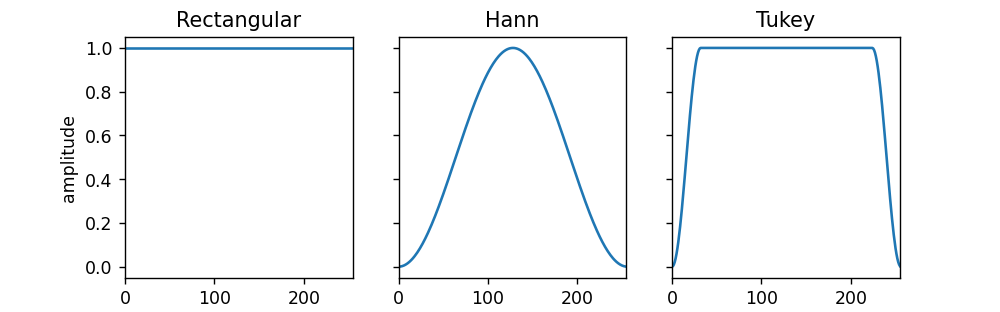

Text(0.5, 0, 'samples')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from scipy import signal

# change alpha between zero and one to see how the Tukey window changes.
alpha = 0.25
nperseg = 256 # samples in each window.

rectangular = np.ones(nperseg)
hann = signal.get_window('hann', nperseg)
tukey = signal.get_window(('tukey', alpha), nperseg)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,2.5), sharey=True, sharex=True)
ax1.set_title('Rectangular')
ax1.plot(rectangular)
ax1.set_xlabel('samples')
ax1.set_ylabel('amplitude')
ax1.set_xlim(0,nperseg-1)
ax2.set_title('Hann')
ax2.plot(hann)
ax2.set_xlabel('samples')
ax3.set_title('Tukey')
ax3.plot(tukey)
ax3.set_xlabel('samples')

To create a spectrogram, let's create a dataset from a chirp function. A chirp function is a sinusoid with constantly varying frequency. It is defined as
$$ x(t) = \cos\left(2\pi\int^t f(s)ds\right) $$
where the $f(t)$ is provided. For the standard chirp function, $f(t)$ is linear
$$ f(t) = at + b$$

In [2]:
dt = 1/500 # sampling rate (in seconds)
a = 5
b = 100
total_t = 10
f = lambda t: a*t + b

'''
f: chirp frequency function
t: time array
total_t: time of signal
'''
def generate_chirp(f, dt, total_t):
    t = np.arange(0, total_t, step=dt)
    # generate x
    x = np.zeros((t.size))
    theta = 0
    for i, t_ in enumerate(t):
        x[i] = np.cos(theta)
        theta += 2*np.pi*f(t_)*dt
    
    return x, t

x, t = generate_chirp(f, dt, total_t)

Now we can create a spectrogram.

<IPython.core.display.Javascript object>


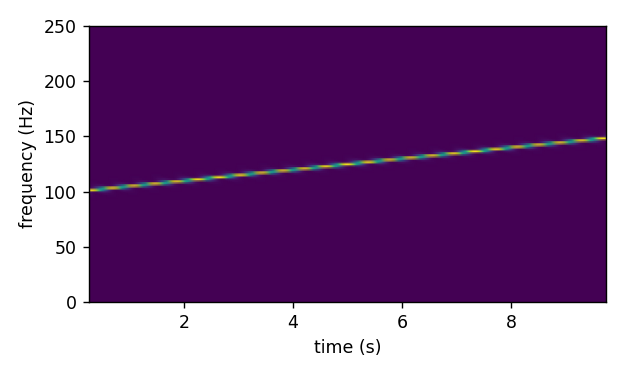

In [3]:
f, t_s, Sxx = signal.spectrogram(x, fs=1/dt, nperseg=256, noverlap=255)

# plot
plt.figure(figsize=(5,3))
plt.pcolormesh(t_s, f, Sxx, shading='gouraud')
plt.ylabel('frequency (Hz)')
plt.xlabel('time (s)')
plt.tight_layout()

**Challenge Problem**

The video below shows a simple experimental setup (from [this](https://github.com/ARTS-Laboratory/dataset-free-vibration-of-cantilever-beam) dataset) with an accelerometer outfitted onto the end of beam. The beam is excited first by-hand, then by the release of a weight. The dataset is loaded below; make a spectrogram of it. Tweak the parameters to make the spectrogram look the best (in your view). (Hint: use `norm='log'` with `pcolormesh` to plot the color in log-scale.)

<video width="800" 
       src="https://github.com/austindowney/dataset-free-vibration-of-cantilever-beam/assets/15316737/d8b73d6f-0344-40fb-b1b2-a755b1d5f9b2"  
       controls>
</video>

<IPython.core.display.Javascript object>


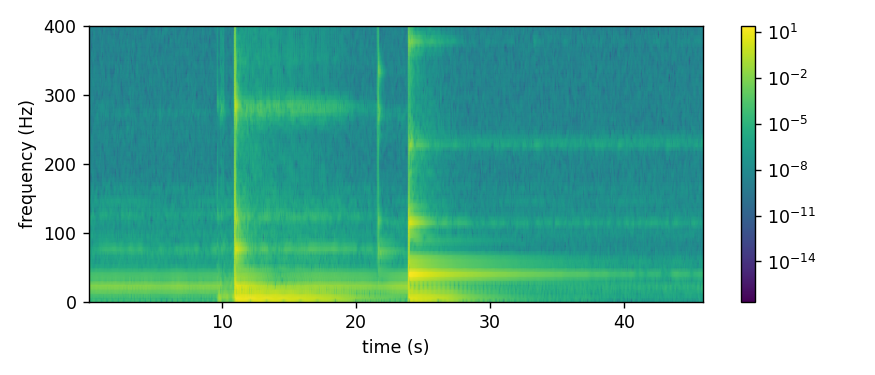

In [4]:
data = np.load('./data/vibration_measurement.npy')
t = data[:,0]
x = data[:,1]

dt = t[1] - t[0]
f, t_s, Sxx = signal.spectrogram(x, fs=1/dt, window=('tukey', .5), nperseg=2**12, noverlap=2**11)

# plot
plt.figure(figsize=(7,3))
plt.pcolormesh(t_s, f, Sxx, shading='gouraud', norm='log')
plt.colorbar()
plt.ylabel('frequency (Hz)')
plt.xlabel('time (s)')
plt.ylim((0, 400))
plt.tight_layout()